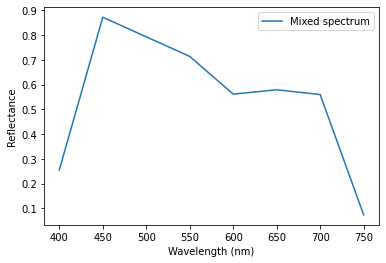

In [1]:
#this is the original algorithm I created to for the hapke equations, we did not have all of the parameters :(

'''
Creating a nonlinear mixing algorithm using the Hapke equations:

1. Gather input data:
   - Obtain the mineral wavelength values for the minerals you want to mix.
   - Gather the corresponding reflectance spectra for each mineral.

2. Normalize the input spectra:
   - Normalize each reflectance spectrum individually to ensure consistent scaling across all minerals. This step helps in the subsequent calculations.

3. Define the Hapke mixing model:
   - The Hapke model characterizes the bidirectional reflectance distribution function (BRDF) of a surface.
   - The Hapke model is nonlinear, involving several parameters such as single scattering albedo, phase function asymmetry factor, and surface roughness.
   - Define the Hapke model equation that best represents your specific application and goals.

4. Initialize the mixing parameters:
   - Determine the number of minerals you want to mix and assign appropriate mixing proportions or weights.
   - Set initial values for other Hapke model parameters (e.g., albedo, asymmetry factor, roughness) based on prior knowledge or experimentation.

5. Implement the mixing algorithm:
   - Iterate through each wavelength value in the input mineral spectra.
   - Calculate the reflectance at each wavelength using the Hapke model equation and the mixing parameters.
   - Combine the reflectance values for each mineral based on the assigned mixing proportions or weights.
   - This process will produce the mixed spectra for the given mineral inputs.

6. Iterate and optimize:
   - To improve the accuracy of the mixing algorithm, you can iteratively adjust the mixing parameters.
   - Use an optimization method (e.g., gradient descent, least squares) to find the optimal values of the mixing parameters that minimize the difference between the mixed spectra and the target spectra.
   - Iterate the mixing algorithm using the updated parameter values until convergence is achieved.

7. Output the mixed spectra:
   - Once the algorithm has converged or reached the desired accuracy, output the final mixed spectra.
'''


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def normalize_spectra(spectra):
    """
    Normalize each reflectance spectrum individually.
    """
    normalized_spectra = []
    for spectrum in spectra:
        normalized_spectrum = spectrum / np.max(spectrum)
        normalized_spectra.append(normalized_spectrum)
    return normalized_spectra

def hapke_model(mu, mu0, g, Se, Si, B, P, H):
    # Equation (5) - Hapke model equation for bidirectional reflectance
    return Se * (mu + mu0) / (mu0 + mu) * ((1 + B) * P + H**2 - 1)

def backscattering_function(G, h, B0):
    # Equation (15) - Backscattering function
    return B0 / (1 + h * np.tan(G))

def particle_phase_function(g, b, c):
    # Equation (16) - Particle scattering phase function
    return 1 + b * np.cos(g) + c * (1.5 * np.cos(g)**2 - 0.5)

def chandrasekhar_function(x):
    # Equation (17) - Chandrasekhar integral multiple scattering function
    return (1 - x) / (1 - x * (1 - 0.5 * x * np.log((1 + 1 / x) / x)))

def mixing_algorithm(wavelengths, mineral_spectra, mixing_proportions, hapke_params, do_normalize):
    assert np.isclose(sum(mixing_proportions), 1), "Mixing proportions must sum to 1"
    assert len(mineral_spectra) == len(mixing_proportions), "Mismatch between number of spectra and number of proportions"
    
    num_minerals = len(mineral_spectra)
    mixed_wavelengths = np.unique(np.concatenate(wavelengths))
    num_wavelengths = len(mixed_wavelengths)

    if do_normalize:
        mineral_spectra = normalize_spectra(mineral_spectra)

    mixed_spectrum = np.zeros(num_wavelengths)

    for mineral_idx in range(num_minerals):
        spectrum = mineral_spectra[mineral_idx]
        proportion = mixing_proportions[mineral_idx]

        # Extract Hapke parameters for the current mineral
        n = hapke_params['n'][mineral_idx]
        k = hapke_params['k'][mineral_idx]
        s = hapke_params['s'][mineral_idx]
        b = hapke_params['b'][mineral_idx]
        c = hapke_params['c'][mineral_idx]
        h = hapke_params['h'][mineral_idx]
        B0 = hapke_params['B0'][mineral_idx]

        R0 = (n**2 + k**2) / (n**2 + k**2 + 1e-10)  # Reflection coefficient for externally incident light
        Se = 0.0587 + 0.8543 * R0 + 0.0870 * R0**2
        Si = 1 - 4 * n * (n + 1) / (n + 1)**2
        P = particle_phase_function(np.deg2rad(hapke_params['phase_angle']), b, c)
        H = chandrasekhar_function(h)
        B = backscattering_function(np.deg2rad(hapke_params['phase_angle']), h, B0)

        interp_spectrum = interp1d(wavelengths[mineral_idx], spectrum, bounds_error=False, fill_value=0)
        spectrum = interp_spectrum(mixed_wavelengths)

        mu = np.cos(np.deg2rad(hapke_params['reflection_angle']))
        mu0 = np.cos(np.deg2rad(hapke_params['incidence_angle']))
        g = np.deg2rad(hapke_params['phase_angle'])

        r = hapke_model(mu, mu0, g, Se, Si, B, P, H)
        mixed_spectrum += proportion * spectrum

    return mixed_wavelengths, mixed_spectrum

# Define minerals and mixing proportions
mineral1_spectrum = np.array([0.6, 0.4, 0.2, 0.8])  # Replace with actual data
mineral2_spectrum = np.array([0.9, 0.8, 0.5, 0.1])  # Replace with actual data
mixing_proportions = [0.34, 0.66]  # Mixing proportions for mineral1 and mineral2

# Define wavelengths for each mineral
mineral1_wavelengths = np.array([400, 500, 600, 700])  # Replace with actual wavelengths for mineral1
mineral2_wavelengths = np.array([450, 550, 650, 750])  # Replace with actual wavelengths for mineral2

# Define Hapke model parameters
hapke_params = {
    'n': [1.5, 2.0],  # Real part of index of refraction for mineral1 and mineral2
    'k': [0.1, 0.2],  # Imaginary part of index of refraction for mineral1 and mineral2
    's': [0.5, 0.3],  # Internal scattering for mineral1 and mineral2
    'b': [0.8, 0.6],  # Scattering anisotropy parameter for mineral1 and mineral2
    'c': [0.4, 0.5],  # Backscattering fraction parameter for mineral1 and mineral2
    'h': [0.2, 0.3],  # Chandrasekhar H-function parameter for mineral1 and mineral2
    'B0': [0.8, 0.9],  # Surface scattering coefficient for mineral1 and mineral2
    'incidence_angle': 30,  # Incidence angle in degrees
    'reflection_angle': 0,  # Reflection angle in degrees
    'phase_angle': 30,  # Phase angle in degrees
}

# Combine mineral spectra and wavelengths into lists
mineral_spectra = [mineral1_spectrum, mineral2_spectrum]
wavelengths = [mineral1_wavelengths, mineral2_wavelengths]

# Ask the user if the spectra are from different sources and need to be normalized
user_input = input("Do the spectra come from different sources and need to be normalized? (yes/no) ")
do_normalize = user_input.lower() == "yes"

# Mix the spectra
mixed_wavelengths, mixed_spectrum = mixing_algorithm(wavelengths, mineral_spectra, mixing_proportions, hapke_params, do_normalize)

# Plot the mixed spectrum
plt.plot(mixed_wavelengths, mixed_spectrum, label='Mixed spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.show()


In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import quadprog
from scipy.optimize import nnls

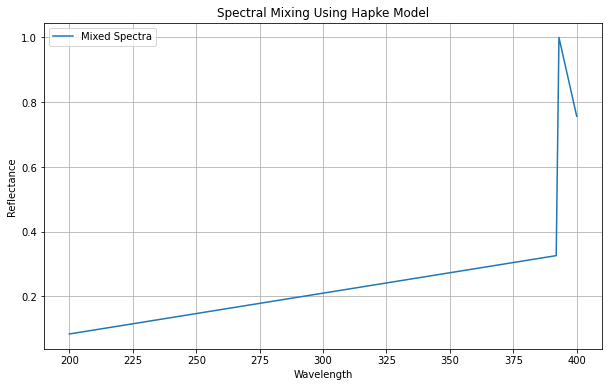

In [3]:
#THIS IS OUR NEW ALGORITHM WITH DUMMY VALUES!

'''
Creating a nonlinear mixing algorithm using the Hapke equations:

1. Gather input data:
   - Obtain the mineral wavelength values for the minerals you want to mix.
   - Gather the corresponding reflectance spectra for each mineral.

2. Normalize the input spectra:
   - Normalize each reflectance spectrum individually to ensure consistent scaling across all minerals. This step helps in the subsequent calculations.

3. Define the Hapke mixing model:
   - The Hapke model characterizes the bidirectional reflectance distribution function (BRDF) of a surface.
   - The Hapke model is nonlinear, involving several parameters such as single scattering albedo, phase function asymmetry factor, and surface roughness.
   - Define the Hapke model equation that best represents your specific application and goals.

4. Initialize the mixing parameters:
   - Determine the number of minerals you want to mix and assign appropriate mixing proportions or weights.
   - Set initial values for other Hapke model parameters (e.g., albedo, asymmetry factor, roughness) based on prior knowledge or experimentation.

5. Implement the mixing algorithm:
   - Iterate through each wavelength value in the input mineral spectra.
   - Calculate the reflectance at each wavelength using the Hapke model equation and the mixing parameters.
   - Combine the reflectance values for each mineral based on the assigned mixing proportions or weights.
   - This process will produce the mixed spectra for the given mineral inputs.

6. Iterate and optimize:
   - To improve the accuracy of the mixing algorithm, you can iteratively adjust the mixing parameters.
   - Use an optimization method (e.g., gradient descent, least squares) to find the optimal values of the mixing parameters that minimize the difference between the mixed spectra and the target spectra.
   - Iterate the mixing algorithm using the updated parameter values until convergence is achieved.

7. Output the mixed spectra:
   - Once the algorithm has converged or reached the desired accuracy, output the final mixed spectra.
'''

def normalize_spectra(spectrum):
    """
    Normalize the reflectance spectrum.
    """
    return spectrum / np.max(spectrum)

def ch(w, x):
    """
    Calculates Chandrasekhar H function
    w - single scatter albedo
    x = mu or mu_0
    """
    y = np.sqrt(1 - w)
    r0 = (1 - y) / (1 + y)
    return 1 / (1 - w * x * (r0 + (1 - 2 * r0 * x) / 2. * np.log((1 + x) / x)))

def reflect(w, mu_0, mu):
    """
    Calculates reflectance of the mixture
    w - single scatter albedo
    mu - cosine of incidence angle
    mu_0 cosine of the emergence angle
    """
    h_mu0 = ch(w, mu_0)
    h_mu = ch(w, mu)
    return w / 4. / (mu_0 + mu) * h_mu0 * h_mu

def wi(n, k, d, lmbda):
    """
    Calculates the single scatter albedo of a component from its optical constants and g
    n - real index of refraction
    k - imaginary index of refraction
    d - grain size
    lmbda - wavelength
    """
    # coefficient of internal attenuation by absorption
    alpha = 4 * np.pi * k / lmbda

    # coefficient of internal attenuation by scattering
    s = 0.

    # internal diffusive reflectance inside a particle
    ri = (1 - np.sqrt(alpha / (alpha + s))) / (1 + np.sqrt(alpha / (alpha + s)))

    # average path length of spherical particles of diameter d
    da = 2. / 3. * (n**2 - 1 / n * (n**2 - 1)**(3. / 2.)) * d

    # particle internal transmission coefficient
    theta = (ri + np.exp(-np.sqrt(alpha * (alpha + s)) * da)) / (1 + ri * np.exp(-np.sqrt(alpha * (alpha + s)) * da))

    # Surface reflection coefficient for externally incident light
    se = ((n - 1)**2 + k**2) / ((n + 1)**2 + k**2) + 0.05

    # Surface reflection coefficient for internally scattered light
    si = 1.014 - 4. / (n * (n + 1)**2)

    # albedo component
    return se + (1 - se) * (1 - si) / (1 - si * theta) * theta

def mixspectra(fi, di, n, k, lmbda):
    """
    Calculates the reflectance of a mixture
    fi - vector of relative cross sections
    di - vector of grain sizes
    n - vector of refractive indices (real part)
    k - vector of refractive indices (imaginary part)
    lmbda - wavelength
    """
    w = np.zeros_like(lmbda) 
    for i in range(len(fi)):
        w = w + fi[i] * wi(n[i], k[i], di[i], lmbda)
    return w

def validate_inputs(mineral_spectra, mixing_proportions, refractive_indices, grain_sizes):
    """
    Validate input parameters before performing calculations.
    """
    assert np.isclose(sum(mixing_proportions), 1), "Mixing proportions must sum to 1"
    assert len(mineral_spectra) == len(mixing_proportions), "Mismatch between number of spectra and number of proportions"
    assert len(refractive_indices['n']) == len(mineral_spectra), "Mismatch between number of spectra and number of refractive indices"
    assert len(grain_sizes) == len(mineral_spectra), "Mismatch between number of spectra and number of grain sizes"

def mixing_algorithm(wavelengths, mineral_spectra, mixing_proportions, refractive_indices, grain_sizes):
    """
    The main function to perform spectral mixing based on Hapke model.
    """
    # Validate inputs
    validate_inputs(mineral_spectra, mixing_proportions, refractive_indices, grain_sizes)

    num_minerals = len(mineral_spectra)
    mixed_wavelengths = np.unique(np.concatenate(wavelengths))
    num_wavelengths = len(mixed_wavelengths)

    mixed_spectrum = np.zeros(num_wavelengths)

    for mineral_idx in range(num_minerals):
        spectrum = mineral_spectra[mineral_idx]
        proportion = mixing_proportions[mineral_idx]

        # Extract parameters for the current mineral
        n = refractive_indices['n'][mineral_idx]
        k = refractive_indices['k'][mineral_idx]
        d = grain_sizes[mineral_idx]
        fi = mixing_proportions[mineral_idx]

        interp_spectrum = interp1d(wavelengths[mineral_idx], spectrum, bounds_error=False, fill_value=0)
        spectrum = interp_spectrum(mixed_wavelengths)

        w = mixspectra([fi], [d], [n], [k], mixed_wavelengths)
        mixed_spectrum += w * spectrum

    # Ask the user if they want to normalize the spectrum
    normalize = input("Does your data originate from different sources? (yes/no): ")
    if normalize.lower() == 'yes':
        mixed_spectrum = normalize_spectra(mixed_spectrum)
    
    return mixed_wavelengths, mixed_spectrum


    # Normalize mixed_spectrum
    mixed_spectrum = normalize_spectra(mixed_spectrum)
    return mixed_wavelengths, mixed_spectrum


def plot_spectrum(wavelengths, spectrum):
    """
    Plot the spectrum based on wavelengths and reflectance.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, spectrum, label='Mixed Spectra')
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    plt.title('Spectral Mixing Using Hapke Model')
    plt.legend()
    plt.grid(True)
    plt.show()


# Test the code with some data (replace with your real data)
wavelengths = [
    np.linspace(400, 200, 100, 800),  # Wavelengths for mineral 1
    np.linspace(400, 393, 100),  # Wavelengths for mineral 2
]
mixing_proportions = [0.5, 0.5]  # Equal mixture of both minerals
# Refractive indices for the two minerals
refractive_indices = {
    'n': [1.5, 1.6],  # Real part of refractive indices
    'k': [0.1, 0.2],  # Imaginary part of refractive indices
}
grain_sizes = [1e-4, 1e-3]  # Grain sizes for the two minerals
mineral_spectra = [
    np.linspace(0.4, 0.1, 100),  # Spectral reflectance for mineral 1
    np.linspace(0.5, 0.8, 100),  # Spectral reflectance for mineral 2
]

mixed_wavelengths, mixed_spectrum = mixing_algorithm(wavelengths, mineral_spectra, mixing_proportions, refractive_indices, grain_sizes)

plot_spectrum(mixed_wavelengths, mixed_spectrum)


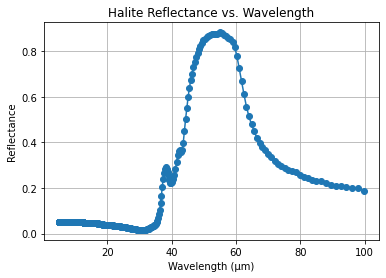

In [4]:
#Here I am just reading in the Halite data (wavelengths,reflectance)and storing it and modeling it

file_path = "halite_spectra.txt"

# Initialize empty lists to store the data
halite_wavlength_values = []
halite_reflectance_values = []

# Read the data from the file and convert wavenumbers to wavelengths
with open(file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and convert values to float
        try:
            x, reflectance = map(float, line.strip().split())
        except ValueError:
            print("Warning: Skipping row with invalid data format:", line)
            continue
        
        # Check if the wavenumber (x) is not zero before conversion
        if x != 0:
            x_in_um = 10000.0 / x  # Convert wavenumber to wavelength
            halite_wavlength_values.append(x_in_um)
            halite_reflectance_values.append(reflectance)
        else:
            print("Warning: Skipping row with wavenumber 0.")

# Proceed with any further processing or analysis using the converted values

# Plot the data
plt.plot(halite_wavlength_values, halite_reflectance_values, marker='o', linestyle='-')
plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Halite Reflectance vs. Wavelength")
plt.grid(True)
plt.show()

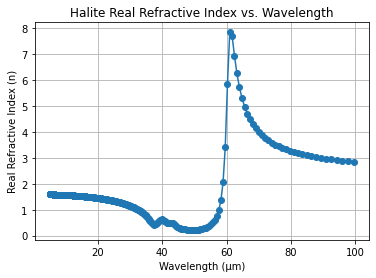

Average Real Refractive Index (halite_real_refractive_index): 1.5573513387423918


In [5]:
#Here I am just reading in the Halite data (wavelengths,real refractive index)and storing it and modeling it

file_path = "halite_real_index.txt"

# Initialize empty lists to store the data
halite_wavlength_values = []
halite_real_refractive_index_values = []

# Read the data from the file and convert wavenumbers to wavelengths
with open(file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and convert values to float
        try:
            x, real_refractive_index = map(float, line.strip().split())
        except ValueError:
            print("Warning: Skipping row with invalid data format:", line)
            continue
        
        # Check if the wavenumber (x) is not zero before conversion
        if x != 0:
            x_in_um = 10000.0 / x  # Convert wavenumber to wavelength
            halite_wavlength_values.append(x_in_um)
            halite_real_refractive_index_values.append(real_refractive_index)
        else:
            print("Warning: Skipping row with wavenumber 0.")

# Calculate the average of the real refractive index values
halite_real_refractive_index = sum(halite_real_refractive_index_values) / len(halite_real_refractive_index_values)

# Proceed with any further processing or analysis using the converted values

# Plot the real refractive index against wavelengths
import matplotlib.pyplot as plt

plt.plot(halite_wavlength_values, halite_real_refractive_index_values, marker='o', linestyle='-')
plt.xlabel("Wavelength (µm)")
plt.ylabel("Real Refractive Index (n)")
plt.title("Halite Real Refractive Index vs. Wavelength")
plt.grid(True)
plt.show()

print("Average Real Refractive Index (halite_real_refractive_index):", halite_real_refractive_index)


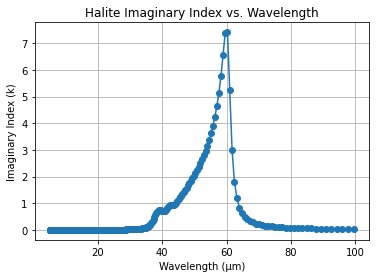

Average Imaginary Index: 0.13231866215618682


In [6]:
#Here I am just reading in the Halite data (wavelengths,imaginary refractive index)and storing it and modeling it

file_path = "halite_imaginary_index.txt"

# Initialize empty lists to store the data
halite_wavlength_values = []
halite_imaginary_index_values = []

# Read the data from the file and convert wavenumbers to wavelengths
with open(file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and convert values to float
        try:
            x, imaginary_index = map(float, line.strip().split())
        except ValueError:
            print("Warning: Skipping row with invalid data format:", line)
            continue
        
        # Check if the wavenumber (x) is not zero before conversion
        if x != 0:
            x_in_um = 10000.0 / x  # Convert wavenumber to wavelength
            halite_wavlength_values.append(x_in_um)
            halite_imaginary_index_values.append(imaginary_index)
        else:
            print("Warning: Skipping row with wavenumber 0.")

# Calculate the average of the imaginary index values
average_imaginary_index = sum(halite_imaginary_index_values) / len(halite_imaginary_index_values)

# Proceed with any further processing or analysis using the converted values

# Plot the imaginary index against wavelengths
import matplotlib.pyplot as plt

plt.plot(halite_wavlength_values, halite_imaginary_index_values, marker='o', linestyle='-')
plt.xlabel("Wavelength (µm)")
plt.ylabel("Imaginary Index (k)")
plt.title("Halite Imaginary Index vs. Wavelength")
plt.grid(True)
plt.show()

print("Average Imaginary Index:", average_imaginary_index)

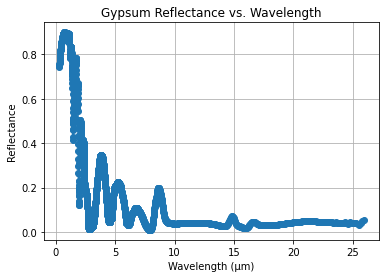

In [7]:
#Here I am just reading in the gypsum data (wavelengths,reflectances)and storing it and modeling it

file_path = "gypsum_spectra.txt"

# Initialize empty lists to store the data
gypsum_wavelength_values = []
gypsum_reflectance_values = []

# Read the data from the file and convert wavenumbers to wavelengths
with open(file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and convert values to float
        try:
            x, reflectance = map(float, line.strip().split())
        except ValueError:
            print("Warning: Skipping row with invalid data format:", line)
            continue
        
        # Check if the wavenumber (x) is not zero before conversion
        if x != 0:
            gypsum_wavelength_values.append(x)
            gypsum_reflectance_values.append(reflectance)
        else:
            print("Warning: Skipping row with wavenumber 0.")

# Proceed with any further processing or analysis using the converted values

# Plot the data
plt.plot(gypsum_wavelength_values, gypsum_reflectance_values, marker='o', linestyle='-')
plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Gypsum Reflectance vs. Wavelength")
plt.grid(True)
plt.show()

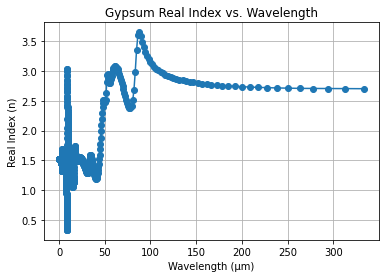

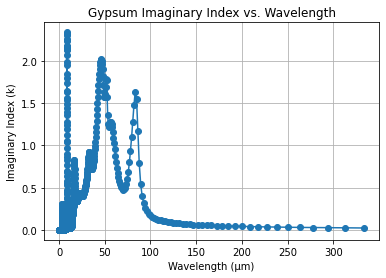

Average Real Index (halite_real_index): 1.533242868842883
Average Imaginary Index (halite_imaginary_index): 0.10973003774564413


In [8]:
#Here I am just reading in the gypsum data (wavelengths,imaginary and imaginary refractive index)and storing it and modeling it

file_path = "gympsum_index.txt"

# Initialize empty lists to store the data
gypsum_wavelength_values = []
gypsum_frequency_values = []
gypsum_real_index_values = []
gypsum_imaginary_index_values = []

# Read the data from the file and convert wavenumbers to wavelengths
with open(file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and convert values to float
        try:
            wavelength, frequency, real_index, imaginary_index = map(float, line.strip().split())
        except ValueError:
            print("Warning: Skipping row with invalid data format:", line)
            continue
        
        # Check if the wavenumber (wavelength) is not zero before conversion
        if wavelength != 0:
            gypsum_wavelength_values.append(wavelength)
            gypsum_frequency_values.append(frequency)
            gypsum_real_index_values.append(real_index)
            gypsum_imaginary_index_values.append(imaginary_index)
        else:
            print("Warning: Skipping row with wavelength 0.")

# Calculate the average of the real index values
halite_real_index = sum(gypsum_real_index_values) / len(gypsum_real_index_values)

# Calculate the average of the imaginary index values
halite_imaginary_index = sum(gypsum_imaginary_index_values) / len(gypsum_imaginary_index_values)

# Proceed with any further processing or analysis using the converted values

# Plot frequency against wavelength for real index
plt.plot(gypsum_wavelength_values, gypsum_real_index_values, marker='o', linestyle='-')
plt.xlabel("Wavelength (µm)")
plt.ylabel("Real Index (n)")
plt.title("Gypsum Real Index vs. Wavelength")
plt.grid(True)
plt.show()

# Plot frequency against wavelength for imaginary index
plt.plot(gypsum_wavelength_values, gypsum_imaginary_index_values, marker='o', linestyle='-')
plt.xlabel("Wavelength (µm)")
plt.ylabel("Imaginary Index (k)")
plt.title("Gypsum Imaginary Index vs. Wavelength")
plt.grid(True)
plt.show()

print("Average Real Index (halite_real_index):", halite_real_index)
print("Average Imaginary Index (halite_imaginary_index):", halite_imaginary_index)


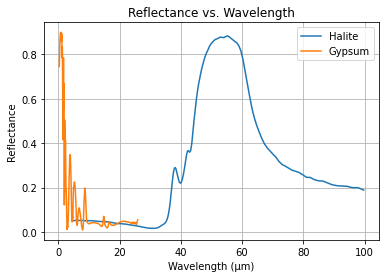

In [9]:
'''
This code reads spectral data from two files, "halite_spectra.txt" and "gypsum_spectra.txt," which contain 
wavelength and reflectance data for halite and gypsum minerals, respectively. It then performs the following steps:

-Converts the wavelength values of halite from cm^-1 to microns.
-Reads and stores the reflectance values for halite and gypsum.
-Creates interpolation functions for the reflectance data of both halite and gypsum 
using the interp1d function from SciPy. The interpolation functions are set to extrapolate values 
outside the original range using the fill_value='extrapolate' argument.
-Finds the absolute minimum and maximum wavelengths from both datasets (halite and gypsum).
-Generates a common set of wavelengths covering the entire range of both minerals using np.linspace.
-interpolates the reflectance data of halite and gypsum to the common set of wavelengths.
-Plots the reflectance of both minerals against their respective wavelengths using matplotlib.
'''

# Function to convert wavelength from cm^-1 to microns
def cm_to_microns(wavelength_cm):
    return 10000.0 / wavelength_cm

# Read data from halite.txt
halite_file_path = "halite_spectra.txt"
halite_wavenumbers = []
halite_reflectance = []

with open(halite_file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and check if it contains valid numeric data
        data = line.strip().split()
        if len(data) == 2:
            try:
                wavenumber, reflectance = map(float, data)
                halite_wavenumbers.append(wavenumber)
                halite_reflectance.append(reflectance)
            except ValueError:
                print("Warning: Skipping row with invalid data format:", line)

# Convert halite wavenumbers to microns
halite_wavelengths = [cm_to_microns(wavenumber) for wavenumber in halite_wavenumbers]

# Read data from gypsum.txt
gypsum_file_path = "gypsum_spectra.txt"
gypsum_wavelengths = []
gypsum_reflectance = []

with open(gypsum_file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and check if it contains valid numeric data
        data = line.strip().split()
        if len(data) == 2:
            try:
                wavelength, reflectance = map(float, data)
                gypsum_wavelengths.append(wavelength)
                gypsum_reflectance.append(reflectance)
            except ValueError:
                print("Warning: Skipping row with invalid data format:", line)

# Create interpolation functions for halite and gypsum reflectance
halite_interp_function = interp1d(halite_wavelengths, halite_reflectance, kind='linear', fill_value='extrapolate')
gypsum_interp_function = interp1d(gypsum_wavelengths, gypsum_reflectance, kind='linear', fill_value='extrapolate')

# Find the absolute minimum and maximum wavelengths from both datasets
min_wavelength = min(min(halite_wavelengths), min(gypsum_wavelengths))
max_wavelength = max(max(halite_wavelengths), max(gypsum_wavelengths))

# Generate common set of wavelengths covering the entire range
common_wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)

# Interpolate halite and gypsum reflectance to the common set of wavelengths
halite_interpolated_reflectance = halite_interp_function(common_wavelengths)
gypsum_interpolated_reflectance = gypsum_interp_function(common_wavelengths)

# Plot both minerals' reflectance against their respective wavelengths
plt.plot(halite_wavelengths, halite_reflectance, label="Halite")
plt.plot(gypsum_wavelengths, gypsum_reflectance, label="Gypsum")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Reflectance vs. Wavelength")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
import numpy as np
import scipy.interpolate as interpolate

# Define the Hapke model for each mineral (this is a simplified version)
def hapke_reflectance(phase_angle_deg, single_scattering_albedo, opposition_surge_coeff):
    phase_angle_rad = np.radians(phase_angle_deg)
    reflectance = single_scattering_albedo * (
        (1 + opposition_surge_coeff * (np.cos(phase_angle_rad) + np.cos(0.0)))
        / (1 + opposition_surge_coeff)
    )
    return reflectance

def interpolate_spectrum(wavelength, reflectance, target_wavelength):
    interp_func = interpolate.interp1d(wavelength, reflectance, kind='linear', fill_value='extrapolate')
    interpolated_reflectance = interp_func(target_wavelength)
    return interpolated_reflectance

def normalize_spectrum(reflectance):
    normalized_reflectance = (reflectance - np.min(reflectance)) / (np.max(reflectance) - np.min(reflectance))
    return normalized_reflectance

# Example usage:
# Assuming wavelength and reflectance spectra for two minerals
wavelength_mineral1 = halite_wavlength_values
reflectance_mineral1 = halite_reflectance_values

wavelength_mineral2 = np.array([550, 600, 650, 700])
reflectance_mineral2 = np.array([0.5, 0.7, 0.9, 1.0])

target_wavelength = np.arange(500, 701, 10)

interpolated_reflectance_mineral1 = interpolate_spectrum(wavelength_mineral1, reflectance_mineral1, target_wavelength)
interpolated_reflectance_mineral2 = interpolate_spectrum(wavelength_mineral2, reflectance_mineral2, target_wavelength)

normalized_reflectance_mineral1 = normalize_spectrum(interpolated_reflectance_mineral1)
normalized_reflectance_mineral2 = normalize_spectrum(interpolated_reflectance_mineral2)

# Hapke parameters for each mineral (example values, you need to provide actual values)
ssalbedo_mineral1 = 0.7
opposition_surge_mineral1 = 0.2
ssalbedo_mineral2 = 0.8
opposition_surge_mineral2 = 0.3

# Assuming weight fraction of the first mineral
weight_fraction_mineral1 = 0.7

# Calculate the reflectance using Hapke model for each mineral
reflectance_hapke_mineral1 = hapke_reflectance(phase_angle_deg=30, single_scattering_albedo=ssalbedo_mineral1, opposition_surge_coeff=opposition_surge_mineral1)
reflectance_hapke_mineral2 = hapke_reflectance(phase_angle_deg=30, single_scattering_albedo=ssalbedo_mineral2, opposition_surge_coeff=opposition_surge_mineral2)

# Nonlinearly combine the reflectance of the minerals using the chosen proportions
mixture_reflectance = weight_fraction_mineral1 * reflectance_hapke_mineral1 + (1 - weight_fraction_mineral1) * reflectance_hapke_mineral2

# Plot the spectra
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(target_wavelength, normalized_reflectance_mineral1, label='Mineral 1 (Interpolated)')
plt.plot(target_wavelength, normalized_reflectance_mineral2, label='Mineral 2 (Interpolated)')
plt.plot(target_wavelength, [mixture_reflectance]*len(target_wavelength), label='Mixture (Hapke Model)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra of Minerals and Mixture (Hapke Model)')
plt.legend()
plt.grid(True)
plt.show()


ValueError: x and y arrays must be equal in length along interpolation axis.

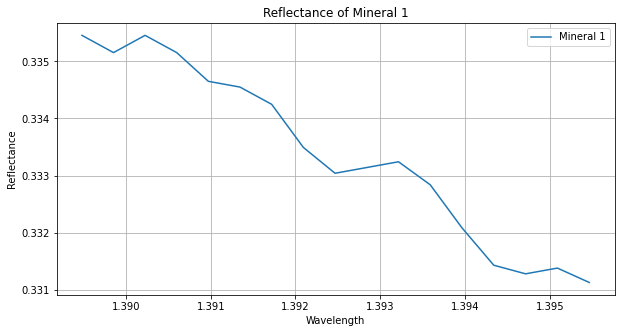

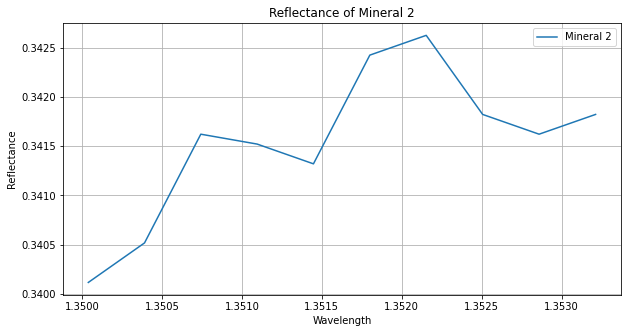

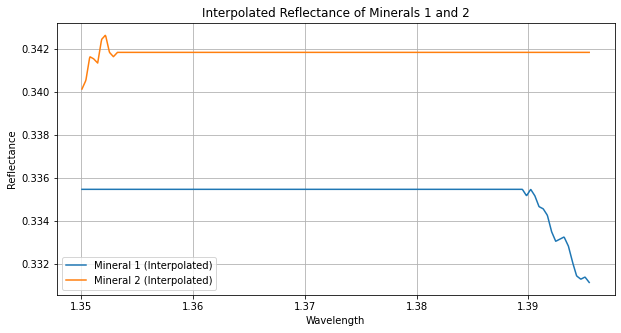

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def linear_interpolation(wavelength, wavelengths, reflectances):
    """
    Perform linear interpolation to estimate the reflectance at a given wavelength.

    Parameters:
        wavelength (float): The wavelength at which the reflectance needs to be interpolated.
        wavelengths (list): List of known wavelengths (in ascending order).
        reflectances (list): List of known reflectances corresponding to wavelengths.

    Returns:
        float: Interpolated reflectance at the given wavelength.
    """

    # Check if wavelength is within the range of known wavelengths
    if wavelength <= wavelengths[0]:
        return reflectances[0]
    elif wavelength >= wavelengths[-1]:
        return reflectances[-1]

    # Find the two closest wavelengths to the given wavelength
    left_index = 0
    right_index = len(wavelengths) - 1

    while right_index - left_index > 1:
        mid_index = (left_index + right_index) // 2
        if wavelengths[mid_index] < wavelength:
            left_index = mid_index
        else:
            right_index = mid_index

    wavelength_left, reflectance_left = wavelengths[left_index], reflectances[left_index]
    wavelength_right, reflectance_right = wavelengths[right_index], reflectances[right_index]

    # Perform linear interpolation
    reflectance_interpolated = (reflectance_left +
                                (wavelength - wavelength_left) /
                                (wavelength_right - wavelength_left) *
                                (reflectance_right - reflectance_left))

    return reflectance_interpolated

# Example data for mineral 1
wavelengths_mineral1 = [1.3894811, 1.3898535, 1.3902262, 1.3905991, 1.3909724, 1.3913456, 1.3917192, 1.3920929, 1.3924669, 1.3928409, 1.3932153, 1.3935897, 1.3939645, 1.3943394, 1.3947146, 1.3950899, 1.3954654]
reflectances_mineral1 = [0.33545622, 0.33515427, 0.33545622, 0.33515427, 0.33465093, 0.33455023, 0.33424827, 0.33349332, 0.33304033, 0.333141, 0.33324167, 0.33283901, 0.33208406, 0.33142972, 0.33127877, 0.33137944, 0.33112776]

# Example data for mineral 2
wavelengths_mineral2 = [1.3500402, 1.3503917, 1.3507435, 1.3510957, 1.3514478, 1.3518003, 1.3521528, 1.3525057, 1.3528585, 1.3532118]
reflectances_mineral2 = [0.34011683, 0.3405183, 0.34162223, 0.34152186, 0.34132117, 0.34242511, 0.34262583, 0.34182295, 0.34162223, 0.34182295]

# Determine the common wavelength range for both minerals
min_wavelength = min(min(wavelengths_mineral1), min(wavelengths_mineral2))
max_wavelength = max(max(wavelengths_mineral1), max(wavelengths_mineral2))

# Create a new wavelength range spanning from min_wavelength to max_wavelength
common_wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)

# Interpolate reflectance values for both minerals at the new common wavelength range
interpolated_reflectances_mineral1 = [linear_interpolation(wavelength, wavelengths_mineral1, reflectances_mineral1) for wavelength in common_wavelengths]
interpolated_reflectances_mineral2 = [linear_interpolation(wavelength, wavelengths_mineral2, reflectances_mineral2) for wavelength in common_wavelengths]

# Plot original data for mineral 1
plt.figure(figsize=(10, 5))
plt.plot(wavelengths_mineral1, reflectances_mineral1, label='Mineral 1')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.title('Reflectance of Mineral 1')
plt.legend()
plt.grid(True)
plt.show()

# Plot original data for mineral 2
plt.figure(figsize=(10, 5))
plt.plot(wavelengths_mineral2, reflectances_mineral2, label='Mineral 2')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.title('Reflectance of Mineral 2')
plt.legend()
plt.grid(True)
plt.show()

# Plot interpolated data for mineral 1 and mineral 2
plt.figure(figsize=(10, 5))
plt.plot(common_wavelengths, interpolated_reflectances_mineral1, label='Mineral 1 (Interpolated)')
plt.plot(common_wavelengths, interpolated_reflectances_mineral2, label='Mineral 2 (Interpolated)')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.title('Interpolated Reflectance of Minerals 1 and 2')
plt.legend()
plt.grid(True)
plt.show()


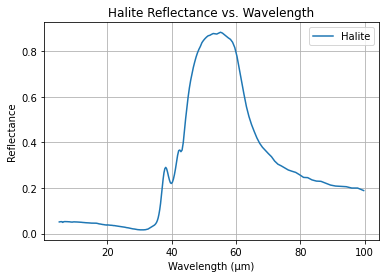

In [20]:
#This is the same code but only plots halite!

# Function to convert wavelength from cm^-1 to microns
def cm_to_microns(wavelength_cm):
    return 10000.0 / wavelength_cm

# Read data from halite.txt
halite_file_path = "halite_spectra.txt"
halite_wavenumbers = []
halite_reflectance = []

with open(halite_file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and check if it contains valid numeric data
        data = line.strip().split()
        if len(data) == 2:
            try:
                wavenumber, reflectance = map(float, data)
                halite_wavenumbers.append(wavenumber)
                halite_reflectance.append(reflectance)
            except ValueError:
                print("Warning: Skipping row with invalid data format:", line)

# Convert halite wavenumbers to microns
halite_wavelengths = [cm_to_microns(wavenumber) for wavenumber in halite_wavenumbers]

# Read data from gypsum.txt
gypsum_file_path = "gypsum_spectra.txt"
gypsum_wavelengths = []
gypsum_reflectance = []

with open(gypsum_file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and check if it contains valid numeric data
        data = line.strip().split()
        if len(data) == 2:
            try:
                wavelength, reflectance = map(float, data)
                gypsum_wavelengths.append(wavelength)
                gypsum_reflectance.append(reflectance)
            except ValueError:
                print("Warning: Skipping row with invalid data format:", line)

# Create interpolation functions for halite and gypsum reflectance
halite_interp_function = interp1d(halite_wavelengths, halite_reflectance, kind='linear', fill_value='extrapolate')
gypsum_interp_function = interp1d(gypsum_wavelengths, gypsum_reflectance, kind='linear', fill_value='extrapolate')

# Find the absolute minimum and maximum wavelengths from both datasets
min_wavelength = min(min(halite_wavelengths), min(gypsum_wavelengths))
max_wavelength = max(max(halite_wavelengths), max(gypsum_wavelengths))

# Generate common set of wavelengths covering the entire range
common_wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)

# Interpolate halite and gypsum reflectance to the common set of wavelengths
halite_interpolated_reflectance = halite_interp_function(common_wavelengths)
gypsum_interpolated_reflectance = gypsum_interp_function(common_wavelengths)

# Plot both minerals' reflectance against their respective wavelengths
plt.plot(halite_wavelengths, halite_reflectance, label="Halite")
#plt.plot(gypsum_wavelengths, gypsum_reflectance, label="Gypsum")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Halite Reflectance vs. Wavelength")
plt.legend()
plt.grid(True)
plt.show()

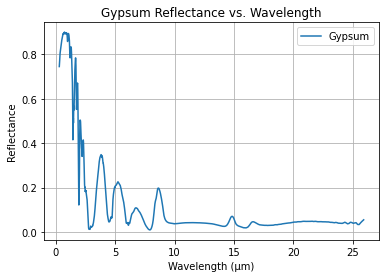

In [24]:
#This is the same code but only plots gypsum!

# Function to convert wavelength from cm^-1 to microns
def cm_to_microns(wavelength_cm):
    return 10000.0 / wavelength_cm

# Read data from halite.txt
halite_file_path = "halite_spectra.txt"
halite_wavenumbers = []
halite_reflectance = []

with open(halite_file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and check if it contains valid numeric data
        data = line.strip().split()
        if len(data) == 2:
            try:
                wavenumber, reflectance = map(float, data)
                halite_wavenumbers.append(wavenumber)
                halite_reflectance.append(reflectance)
            except ValueError:
                print("Warning: Skipping row with invalid data format:", line)

# Convert halite wavenumbers to microns
halite_wavelengths = [cm_to_microns(wavenumber) for wavenumber in halite_wavenumbers]

# Read data from gypsum.txt
gypsum_file_path = "gypsum_spectra.txt"
gypsum_wavelengths = []
gypsum_reflectance = []

with open(gypsum_file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and check if it contains valid numeric data
        data = line.strip().split()
        if len(data) == 2:
            try:
                wavelength, reflectance = map(float, data)
                gypsum_wavelengths.append(wavelength)
                gypsum_reflectance.append(reflectance)
            except ValueError:
                print("Warning: Skipping row with invalid data format:", line)

# Create interpolation functions for halite and gypsum reflectance
halite_interp_function = interp1d(halite_wavelengths, halite_reflectance, kind='linear', fill_value='extrapolate')
gypsum_interp_function = interp1d(gypsum_wavelengths, gypsum_reflectance, kind='linear', fill_value='extrapolate')

# Find the absolute minimum and maximum wavelengths from both datasets
min_wavelength = min(min(halite_wavelengths), min(gypsum_wavelengths))
max_wavelength = max(max(halite_wavelengths), max(gypsum_wavelengths))

# Generate common set of wavelengths covering the entire range
common_wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)

# Interpolate halite and gypsum reflectance to the common set of wavelengths
halite_interpolated_reflectance = halite_interp_function(common_wavelengths)
gypsum_interpolated_reflectance = gypsum_interp_function(common_wavelengths)

# Plot both minerals' reflectance against their respective wavelengths
#plt.plot(halite_wavelengths, halite_reflectance, label="Halite")
plt.plot(gypsum_wavelengths, gypsum_reflectance, label="Gypsum")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Gypsum Reflectance vs. Wavelength")
plt.legend()
plt.grid(True)
plt.show()

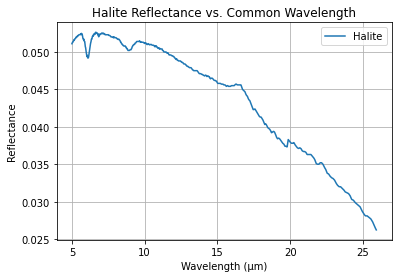

In [15]:
#This code does the same thing but only plots halite along the comment set of wavelengths

# Function to convert wavelength from cm^-1 to microns
def cm_to_microns(wavelength_cm):
    return 10000.0 / wavelength_cm

# Read data from halite.txt
halite_file_path = "halite_spectra.txt"
halite_wavenumbers = []
halite_reflectance = []

with open(halite_file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and check if it contains valid numeric data
        data = line.strip().split()
        if len(data) == 2:
            try:
                wavenumber, reflectance = map(float, data)
                halite_wavenumbers.append(wavenumber)
                halite_reflectance.append(reflectance)
            except ValueError:
                print("Warning: Skipping row with invalid data format:", line)

# Convert halite wavenumbers to microns
halite_wavelengths = [cm_to_microns(wavenumber) for wavenumber in halite_wavenumbers]

# Read data from gypsum.txt
gypsum_file_path = "gypsum_spectra.txt"
gypsum_wavelengths = []
gypsum_reflectance = []

with open(gypsum_file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and check if it contains valid numeric data
        data = line.strip().split()
        if len(data) == 2:
            try:
                wavelength, reflectance = map(float, data)
                gypsum_wavelengths.append(wavelength)
                gypsum_reflectance.append(reflectance)
            except ValueError:
                print("Warning: Skipping row with invalid data format:", line)

# Create interpolation functions for halite and gypsum reflectance
halite_interp_function = interp1d(halite_wavelengths, halite_reflectance, kind='linear', fill_value='extrapolate')
gypsum_interp_function = interp1d(gypsum_wavelengths, gypsum_reflectance, kind='linear', fill_value='extrapolate')

# Determine the common set of wavelengths covering the desired range
min_wavelength = max(min(halite_wavelengths), min(gypsum_wavelengths))
max_wavelength = min(max(halite_wavelengths), max(gypsum_wavelengths))
common_wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)

# Interpolate halite and gypsum reflectance to the common set of wavelengths
halite_interpolated_reflectance = halite_interp_function(common_wavelengths)
gypsum_interpolated_reflectance = gypsum_interp_function(common_wavelengths)

# Plot both minerals' reflectance against the common set of wavelengths
plt.plot(common_wavelengths, halite_interpolated_reflectance, label="Halite")
#plt.plot(common_wavelengths, gypsum_interpolated_reflectance, label="Gypsum")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Halite Reflectance vs. Common Wavelength")
plt.legend()
plt.grid(True)
plt.show()

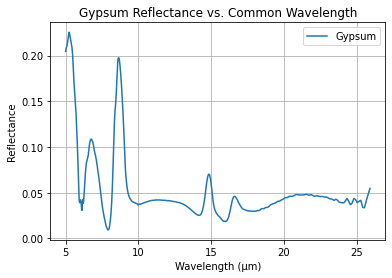

In [26]:
#This code does the same thing but only plots gypsum along the comment set of wavelengths

# Function to convert wavelength from cm^-1 to microns
def cm_to_microns(wavelength_cm):
    return 10000.0 / wavelength_cm

# Read data from halite.txt
halite_file_path = "halite_spectra.txt"
halite_wavenumbers = []
halite_reflectance = []

with open(halite_file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and check if it contains valid numeric data
        data = line.strip().split()
        if len(data) == 2:
            try:
                wavenumber, reflectance = map(float, data)
                halite_wavenumbers.append(wavenumber)
                halite_reflectance.append(reflectance)
            except ValueError:
                print("Warning: Skipping row with invalid data format:", line)

# Convert halite wavenumbers to microns
halite_wavelengths = [cm_to_microns(wavenumber) for wavenumber in halite_wavenumbers]

# Read data from gypsum.txt
gypsum_file_path = "gypsum_spectra.txt"
gypsum_wavelengths = []
gypsum_reflectance = []

with open(gypsum_file_path, 'r') as file:
    # Skip the first line (header)
    next(file)
    
    for line in file:
        # Split the line by whitespace and check if it contains valid numeric data
        data = line.strip().split()
        if len(data) == 2:
            try:
                wavelength, reflectance = map(float, data)
                gypsum_wavelengths.append(wavelength)
                gypsum_reflectance.append(reflectance)
            except ValueError:
                print("Warning: Skipping row with invalid data format:", line)

# Create interpolation functions for halite and gypsum reflectance
halite_interp_function = interp1d(halite_wavelengths, halite_reflectance, kind='linear', fill_value='extrapolate')
gypsum_interp_function = interp1d(gypsum_wavelengths, gypsum_reflectance, kind='linear', fill_value='extrapolate')

# Determine the common set of wavelengths covering the desired range
min_wavelength = max(min(halite_wavelengths), min(gypsum_wavelengths))
max_wavelength = min(max(halite_wavelengths), max(gypsum_wavelengths))
common_wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)

# Interpolate halite and gypsum reflectance to the common set of wavelengths
halite_interpolated_reflectance = halite_interp_function(common_wavelengths)
gypsum_interpolated_reflectance = gypsum_interp_function(common_wavelengths)

# Plot both minerals' reflectance against the common set of wavelengths
#plt.plot(common_wavelengths, halite_interpolated_reflectance, label="Halite")
plt.plot(common_wavelengths, gypsum_interpolated_reflectance, label="Gypsum")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Reflectance")
plt.title("Gypsum Reflectance vs. Common Wavelength")
plt.legend()
plt.grid(True)
plt.show()


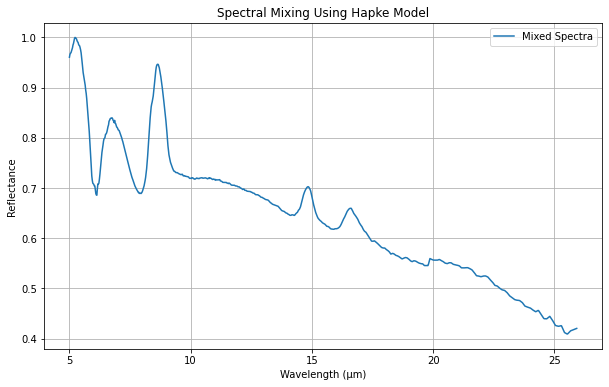

In [30]:

'''
Creating a nonlinear mixing algorithm using the Hapke equations:

1. Gather input data:
   - Obtain the mineral wavelength values for the minerals you want to mix.
   - Gather the corresponding reflectance spectra for each mineral.

2. Normalize the input spectra:
   - Normalize each reflectance spectrum individually to ensure consistent scaling across all minerals. This step helps in the subsequent calculations.

3. Define the Hapke mixing model:
   - The Hapke model characterizes the bidirectional reflectance distribution function (BRDF) of a surface.
   - The Hapke model is nonlinear, involving several parameters such as single scattering albedo, phase function asymmetry factor, and surface roughness.
   - Define the Hapke model equation that best represents your specific application and goals.

4. Initialize the mixing parameters:
   - Determine the number of minerals you want to mix and assign appropriate mixing proportions or weights.
   - Set initial values for other Hapke model parameters (e.g., albedo, asymmetry factor, roughness) based on prior knowledge or experimentation.

5. Implement the mixing algorithm:
   - Iterate through each wavelength value in the input mineral spectra.
   - Calculate the reflectance at each wavelength using the Hapke model equation and the mixing parameters.
   - Combine the reflectance values for each mineral based on the assigned mixing proportions or weights.
   - This process will produce the mixed spectra for the given mineral inputs.

6. Iterate and optimize:
   - To improve the accuracy of the mixing algorithm, you can iteratively adjust the mixing parameters.
   - Use an optimization method (e.g., gradient descent, least squares) to find the optimal values of the mixing parameters that minimize the difference between the mixed spectra and the target spectra.
   - Iterate the mixing algorithm using the updated parameter values until convergence is achieved.

7. Output the mixed spectra:
   - Once the algorithm has converged or reached the desired accuracy, output the final mixed spectra.
'''


def normalize_spectra(spectrum):
    """
    Normalize the reflectance spectrum.
    """
    return spectrum / np.max(spectrum)

def ch(w, x):
    """
    Calculates Chandrasekhar H function
    w - single scatter albedo
    x = mu or mu_0
    """
    y = np.sqrt(1 - w)
    r0 = (1 - y) / (1 + y)
    return 1 / (1 - w * x * (r0 + (1 - 2 * r0 * x) / 2. * np.log((1 + x) / x)))

def reflect(w, mu_0, mu):
    """
    Calculates reflectance of the mixture
    w - single scatter albedo
    mu - cosine of incidence angle
    mu_0 cosine of the emergence angle
    """
    h_mu0 = ch(w, mu_0)
    h_mu = ch(w, mu)
    return w / 4. / (mu_0 + mu) * h_mu0 * h_mu

def wi(n, k, d, lmbda):
    """
    Calculates the single scatter albedo of a component from its optical constants and g
    n - real index of refraction
    k - imaginary index of refraction
    d - grain size
    lmbda - wavelength
    """
    # coefficient of internal attenuation by absorption
    alpha = 4 * np.pi * k / lmbda

    # coefficient of internal attenuation by scattering
    s = 0.

    # internal diffusive reflectance inside a particle
    ri = (1 - np.sqrt(alpha / (alpha + s))) / (1 + np.sqrt(alpha / (alpha + s)))

    # average path length of spherical particles of diameter d
    da = 2. / 3. * (n**2 - 1 / n * (n**2 - 1)**(3. / 2.)) * d

    # particle internal transmission coefficient
    theta = (ri + np.exp(-np.sqrt(alpha * (alpha + s)) * da)) / (1 + ri * np.exp(-np.sqrt(alpha * (alpha + s)) * da))

    # Surface reflection coefficient for externally incident light
    se = ((n - 1)**2 + k**2) / ((n + 1)**2 + k**2) + 0.05

    # Surface reflection coefficient for internally scattered light
    si = 1.014 - 4. / (n * (n + 1)**2)

    # albedo component
    return se + (1 - se) * (1 - si) / (1 - si * theta) * theta

def mixspectra(fi, di, n, k, lmbda):
    """
    Calculates the reflectance of a mixture
    fi - vector of relative cross sections
    di - vector of grain sizes
    n - vector of refractive indices (real part)
    k - vector of refractive indices (imaginary part)
    lmbda - wavelength
    """
    w = np.zeros_like(lmbda) 
    for i in range(len(fi)):
        w = w + fi[i] * wi(n[i], k[i], di[i], lmbda)
    return w

def validate_inputs(mineral_spectra, mixing_proportions, refractive_indices, grain_sizes):
    """
    Validate input parameters before performing calculations.
    """
    assert np.isclose(sum(mixing_proportions), 1), "Mixing proportions must sum to 1"
    assert len(mineral_spectra) == len(mixing_proportions), "Mismatch between number of spectra and number of proportions"
    assert len(refractive_indices['n']) == len(mineral_spectra), "Mismatch between number of spectra and number of refractive indices"
    assert len(grain_sizes) == len(mineral_spectra), "Mismatch between number of spectra and number of grain sizes"

def mixing_algorithm(wavelengths, mineral_spectra, mixing_proportions, refractive_indices, grain_sizes):
    """
    The main function to perform spectral mixing based on Hapke model.
    """
    # Validate inputs
    validate_inputs(mineral_spectra, mixing_proportions, refractive_indices, grain_sizes)

    num_minerals = len(mineral_spectra)
    mixed_wavelengths = np.unique(np.concatenate(wavelengths))
    num_wavelengths = len(mixed_wavelengths)

    mixed_spectrum = np.zeros(num_wavelengths)

    for mineral_idx in range(num_minerals):
        spectrum = mineral_spectra[mineral_idx]
        proportion = mixing_proportions[mineral_idx]

        # Extract parameters for the current mineral
        n = refractive_indices['n'][mineral_idx]
        k = refractive_indices['k'][mineral_idx]
        d = grain_sizes[mineral_idx]
        fi = mixing_proportions[mineral_idx]

        interp_spectrum = interp1d(wavelengths[mineral_idx], spectrum, bounds_error=False, fill_value=0)
        spectrum = interp_spectrum(mixed_wavelengths)

        w = mixspectra([fi], [d], [n], [k], mixed_wavelengths)
        mixed_spectrum += w * spectrum

    # Ask the user if they want to normalize the spectrum
    normalize = input("Does your data originate from different sources? (yes/no): ")
    if normalize.lower() == 'yes':
        mixed_spectrum = normalize_spectra(mixed_spectrum)
    
    return mixed_wavelengths, mixed_spectrum


    # Normalize mixed_spectrum
    mixed_spectrum = normalize_spectra(mixed_spectrum)
    return mixed_wavelengths, mixed_spectrum


def plot_spectrum(wavelengths, spectrum):
    """
    Plot the spectrum based on wavelengths and reflectance.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, spectrum, label='Mixed Spectra')
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Reflectance')
    plt.title('Spectral Mixing Using Hapke Model')
    plt.legend()
    plt.grid(True)
    plt.show()


# Test the code with some data (replace with your real data)
wavelengths = [
    common_wavelengths,  # Wavelengths for mineral 1
    common_wavelengths,  # Wavelengths for mineral 2
]
mixing_proportions = [0.90, 0.1]  # Equal mixture of both minerals
# Refractive indices for the two minerals
refractive_indices = {
    'n': [1.5573513387423918,  1.083],  # Real part of refractive indices
    'k': [0.93231866215618682, 0.10973003774564413],  # Imaginary part of refractive indices
}
grain_sizes = [1e-7, 1e-9]  # Grain sizes for the two minerals
mineral_spectra = [
    halite_interpolated_reflectance,  # Spectral reflectance for mineral 1
    gypsum_interpolated_reflectance,  # Spectral reflectance for mineral 2
]


mixed_wavelengths, mixed_spectrum = mixing_algorithm(wavelengths, mineral_spectra, mixing_proportions, refractive_indices, grain_sizes)

plot_spectrum(mixed_wavelengths, mixed_spectrum)
